# HW4 problem 3

Seokjun Choi

*Code blocks are Python scripts in this problem.*

*Executable stand-alone Python script: https://github.com/letsjdosth/GLM/blob/main/hw4q3c.py*

*This code depends on third-party packages*
- numpy
- matplotlib

and another python module that I implemented,
- MCMC_Core: *https://github.com/letsjdosth/GLM/blob/main/pyBayes/MCMC_Core.py*

*All scripts are tested in Python 3.10.5 64-bit, in Windows 10.*

## 3-(c)

Using the result from (a), I will run two MCMC chains separately, using prior $p(\alpha_1,\beta_1,\alpha_2,\beta_2) = p(\alpha_1, \beta_1)p(\alpha_2, \beta_2)$ and

- $\alpha_1, \beta_1 \sim N(0, diag(10^2, 10^2))$
- $\alpha_2, \beta_2 \sim N(0, diag(10^2, 10^2))$

For proposal distributions in MCMC steps, I set normal distributions with standard deviation the same as MLE's SE in 3-(b).
As you recommended in a lecture, it works very well.

I show traceplots, acf plots, and histograms with posterior means(vertical solid red line), medians(vertical dashed red line), and 95% centered credible intervals (horizontal solid red line). Please see its y-label to see which graph is for which parameter for each plot. Not only that, I make a summary table of posterior mean, variance, and 95% credible interval based on the generated samples.

In [4]:
from random import seed, normalvariate
from math import exp, log
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

from pyBayes import MCMC_Core

seed(20221120)

#data
concentration = np.array([0, 62.5, 125, 250, 500])
response_dead = np.array([15, 17, 22, 38, 144])
response_malformation = np.array([1, 0, 7, 59, 132])
response_normal = np.array([281, 225, 283, 202, 9])
num_subject = response_dead + response_malformation + response_normal

data_L1 = [(x, m, y1) for x,y1,_,_,m in zip(concentration, response_dead, response_malformation, response_normal, num_subject)]
data_L2 = [(x, m-y1, y2) for x,y1,y2,_,m in zip(concentration, response_dead, response_malformation, response_normal, num_subject)]

def logit_posterior_with_flat_prior(beta, data):
    log_post = 0
    for (x, m, y) in data:
        nu = beta[0] + beta[1]*x
        log_post += (y*nu - m*log(1+exp(nu)))
    return log_post

def logit_posterior_with_normal_prior(beta, data, sigma1, sigma2):
    log_post = logit_posterior_with_flat_prior(beta, data)
    log_post += (-0.5*beta[0]**2/(sigma1**2) - 0.5*beta[1]**2/(sigma2**2))
    return log_post

def symmetric_proposal_placeholder(from_smpl, to_smpl):
    #for log_proposal
    return 0

def normal_proposal_sampler(from_smpl, proposal_sigma_vec):
    return [normalvariate(x, proposal_sigma_vec[i]) for i,x in enumerate(from_smpl)]

def pi_plot(posterior_samples_L1, posterior_samples_L2, set_x_axis, show=True): #depend on data (not first-class function!)
    def inv_logit_link(x, params):
        # params: [beta1, beta2]
        nu = params[0]+params[1]*x
        return exp((nu))/(1+exp(nu))

    x_grid = np.arange(set_x_axis[0], set_x_axis[1], set_x_axis[2])
    pi1_lwr = []
    pi1_med = []
    pi1_upr = []
    pi1_avg = []
    pi2_lwr = []
    pi2_med = []
    pi2_upr = []
    pi2_avg = []
    pi3_lwr = []
    pi3_med = []
    pi3_upr = []
    pi3_avg = []
    for x in x_grid:
        rho1_samples_at_x = np.array([inv_logit_link(x, params) for params in posterior_samples_L1])
        rho2_samples_at_x = np.array([inv_logit_link(x, params) for params in posterior_samples_L2])
        
        pi1_samples_at_x = rho1_samples_at_x
        pi2_samples_at_x = rho2_samples_at_x * (1 - pi1_samples_at_x)
        pi3_samples_at_x = 1 - pi1_samples_at_x - pi2_samples_at_x

        pi1_lwr.append(float(np.quantile(pi1_samples_at_x, 0.025)))
        pi1_med.append(float(np.quantile(pi1_samples_at_x, 0.5)))
        pi1_upr.append(float(np.quantile(pi1_samples_at_x, 0.975)))
        pi1_avg.append(float(np.mean(pi1_samples_at_x)))
        pi2_lwr.append(float(np.quantile(pi2_samples_at_x, 0.025)))
        pi2_med.append(float(np.quantile(pi2_samples_at_x, 0.5)))
        pi2_upr.append(float(np.quantile(pi2_samples_at_x, 0.975)))
        pi2_avg.append(float(np.mean(pi2_samples_at_x)))
        pi3_lwr.append(float(np.quantile(pi3_samples_at_x, 0.025)))
        pi3_med.append(float(np.quantile(pi3_samples_at_x, 0.5)))
        pi3_upr.append(float(np.quantile(pi3_samples_at_x, 0.975)))
        pi3_avg.append(float(np.mean(pi3_samples_at_x)))

    plt.ylim([0, 1.05])
    plt.plot(x_grid, pi1_avg, color="black", linestyle="solid")
    plt.plot(x_grid, pi1_med, color="black", linestyle="dashed")
    plt.plot(x_grid, pi1_lwr, color="grey")
    plt.plot(x_grid, pi1_upr, color="grey")
    plt.plot(x_grid, pi2_avg, color="red", linestyle="solid")
    plt.plot(x_grid, pi2_med, color="red", linestyle="dashed")
    plt.plot(x_grid, pi2_lwr, color="grey")
    plt.plot(x_grid, pi2_upr, color="grey")
    plt.plot(x_grid, pi3_avg, color="blue", linestyle="solid")
    plt.plot(x_grid, pi3_med, color="blue", linestyle="dashed")
    plt.plot(x_grid, pi3_lwr, color="grey")
    plt.plot(x_grid, pi3_upr, color="grey")
    
    plt.plot([x for x in concentration], [y1/m for m, y1 in zip(num_subject, response_dead)], marker="o", color="black", linestyle="dotted")
    plt.plot([x for x in concentration], [y2/m for m, y2 in zip(num_subject, response_malformation)], marker="o", color="red", linestyle="dotted")
    plt.plot([x for x in concentration], [y3/m for m, y3 in zip(num_subject, response_normal)], marker="o", color="blue", linestyle="dotted")
    if show:
        plt.show()


estimated running time:  0.0 min  2.99072265625 sec
iteration 20000 / 100000
iteration 40000 / 100000
iteration 60000 / 100000
iteration 80000 / 100000
iteration 100000 / 100000  done! (elapsed time for execution:  0.0 min  3.7724292278289795 sec)
acceptance rate:  0.3544
param 		 mean 	 var 	 95%CI
alpha1 		 -3.249499 	 0.024172 	 [-3.557867, -2.949606]
beta1 		 0.00639 	 0.0 	 [0.005557, 0.007238]


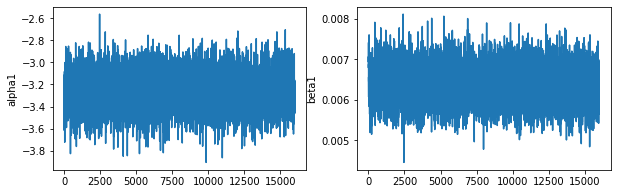

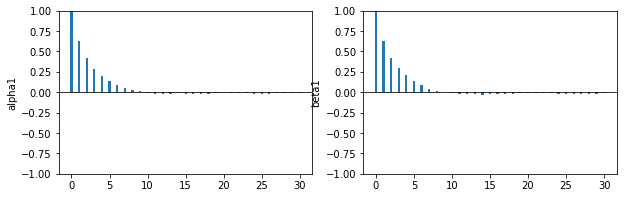

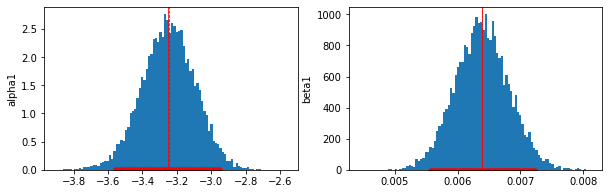

estimated running time:  0.0 min  2.9516220092773438 sec
iteration 20000 / 100000
iteration 40000 / 100000
iteration 60000 / 100000
iteration 80000 / 100000
iteration 100000 / 100000  done! (elapsed time for execution:  0.0 min  3.453777313232422 sec)
acceptance rate:  0.2849
param 		 mean 	 var 	 95%CI
alpha2 		 -5.756041 	 0.113159 	 [-6.44627, -5.127728]
beta2 		 0.017584 	 2e-06 	 [0.015253, 0.020173]


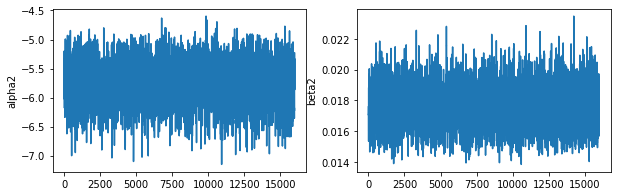

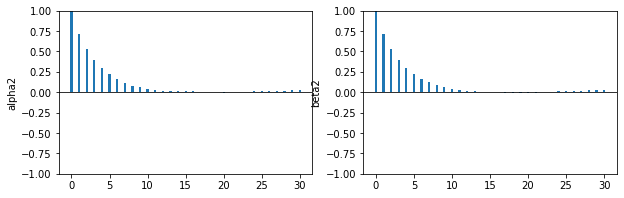

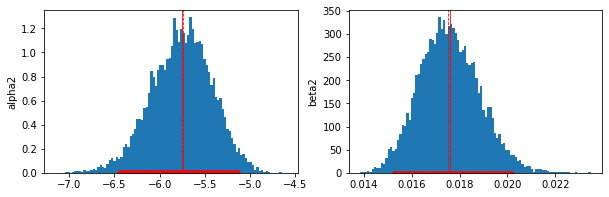

In [2]:

#L1_part_fit
part_L1_initial = [0,0]
part_L1_inst = MCMC_Core.MCMC_MH(
                partial(logit_posterior_with_normal_prior, data=data_L1, sigma1=10, sigma2=10),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[0.15766, 0.00043]), #from 4b
                part_L1_initial)
part_L1_inst.generate_samples(100000, print_iter_cycle=20000)
part_L1_diag = MCMC_Core.MCMC_Diag()
part_L1_diag.set_mc_sample_from_MCMC_instance(part_L1_inst)
part_L1_diag.set_variable_names(["alpha1", "beta1"])
part_L1_diag.burnin(20000)
part_L1_diag.thinning(5)
part_L1_diag.print_summaries(6)
part_L1_diag.show_traceplot((1,2))
part_L1_diag.show_acf(30, (1,2))
part_L1_diag.show_hist((1,2))

#L2 part fit
part_L2_initial = [0,0]
part_L2_inst = MCMC_Core.MCMC_MH(
                partial(logit_posterior_with_normal_prior, data=data_L2, sigma1=10, sigma2=10),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[0.33225, 0.00123]), #from 4b
                part_L2_initial)
part_L2_inst.generate_samples(100000, print_iter_cycle=20000)
part_L2_diag = MCMC_Core.MCMC_Diag()
part_L2_diag.set_mc_sample_from_MCMC_instance(part_L2_inst)
part_L2_diag.set_variable_names(["alpha2", "beta2"])
part_L2_diag.burnin(20000)
part_L2_diag.thinning(5)
part_L2_diag.print_summaries(6)
part_L2_diag.show_traceplot((1,2))
part_L2_diag.show_acf(30, (1,2))
part_L2_diag.show_hist((1,2))



Point estimates are very similar to MLE fit.

Using samples from both chains, I will construct a plot of $\pi_1, \pi_2, \pi_3$ over 'concentration' axis.

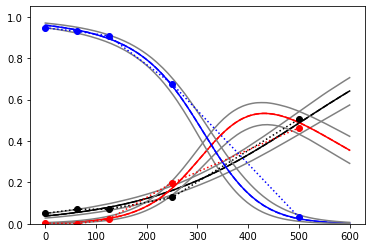

In [5]:
#pi-plot
pi_plot(part_L1_diag.MC_sample, part_L2_diag.MC_sample, (0, 601, 2))


The black solid curve indicates $\pi_1$, the red is $\pi_2$, and the blue means $\pi_3$.
Gray curves are for 95% credible intervals for each $\pi_j$, $j=1,2,3$.

Dots are observation $y_ij/m_i$, with colors consisting of the lines' colors.
Dashed lines are a sort of 'naive' estimation using linear interpolation by connecting realized observations.

Generally, the result is almost the same as the MLE fit.

We can see a huge difference between naive linear interpolation and our model fit when 'concentration' is between 250 and 500. The $\pi_2$ fit from our model is attractive in particular cause its direction is reversed around 450 to make $\pi_1$ increase at high-level concentration. It makes sense for our intuition if we think of their meaning. If the toxin level gets very high, mice die instead of being malformed.